# Plain vs. Skip Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def myimgshow(plt,img):
    plt.gray()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

## Test skipnet

In [15]:
output_depth = 1
num_layers = 5
num_channels = num_layers * 2
skipnet = skipdecoder(output_depth,num_layers,num_channels,skips=True).type(dtype)

print(skipnet)

totalupsample = 2**num_layers
width = 2*totalupsample
height = 2*totalupsample
shape = [1,num_channels, width, height]
print("shape: ", shape)
net_input = Variable(torch.zeros(shape)).type(dtype)
net_input.data.uniform_()
net_input.data *= 1./10



Sequential(
  (1): skip_model(
    (upsamp): Upsample(scale_factor=2.0, mode=bilinear)
    (act_fun): ReLU()
    (sig): Sigmoid()
    (net1): Sequential(
      (1): Upsample(scale_factor=2.0, mode=bilinear)
      (2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): ReLU()
      (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Upsample(scale_factor=2.0, mode=bilinear)
      (6): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): ReLU()
      (8): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Upsample(scale_factor=2.0, mode=bilinear)
      (10): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (11): ReLU()
      (12): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): Upsample(scale_factor=2.0, mode=bilinear)
      (14): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (15)

AttributeError: 'Sequential' object has no attribute 'skip_model'

## Load image

In [2]:
path = './test_data/'
#img_name = "phantom256"
img_name = "brain_sagittal.jpg"
img_path = path + img_name #+ ".png"
img_pil = Image.open(img_path)
img_np = np.array([pil_to_np(img_pil)[0]])
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)

In [3]:
img_np.shape,img_var.shape

((1, 256, 256), torch.Size([1, 1, 256, 256]))

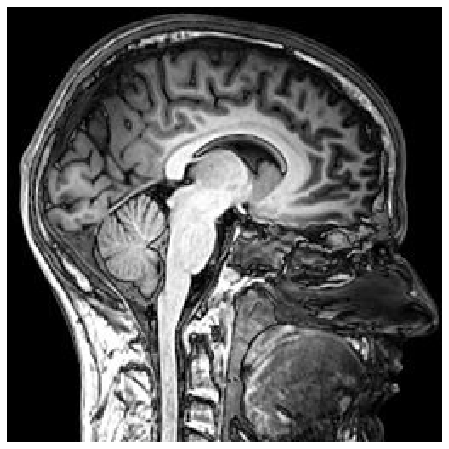

In [41]:
myimgshow(plt,img_np)
plt.axis('off')
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

## Define network

In [38]:
skip_psnr = []
skip_params = []
plain_psnr = []
plain_params = []
output_depth = img_np.shape[0]
num_channels = 64
rnd = 500
numit = 30000
rn = 0.001
maxv = np.max(img_np)
for num_layers in [2,3,4,5,6]:
    
    skipnet = skipdecoder(output_depth,num_layers,num_channels,skips=True).type(dtype)
    skip_params.append(num_param(skipnet))
    
    plainnet = skipdecoder(output_depth,num_layers,num_channels,skips=False).type(dtype)
    plain_params.append(num_param(plainnet))
    


    mse_n, mse_t, skipni, skipnet = fit( num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=0.0025,
                            img_noisy_var=img_var,
                            net=skipnet,
                            img_clean_var=img_var,
                            find_best=True,
                            )
    out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
    skip_psnr.append(psnr(img_np,out_img_np,maxv))
    
    mse_n, mse_t, plainni, plainnet = fit( num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=0.0025,
                            img_noisy_var=img_var,
                            net=plainnet,
                            img_clean_var=img_var,
                            find_best=True,
                            #orth_reg=0.1,
                            )    
    out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
    plain_psnr.append(psnr(img_np,out_img_np,maxv)) 

shape:  [1, 64, 128, 128]
optimize with adam 0.0025
shape:  [1, 64, 128, 128]loss 0.059544  Actual loss 0.059544 Actual loss orig 0.059544  Noise Energy 0.000000 
optimize with adam 0.0025
shape:  [1, 64, 64, 64]n loss 0.058770  Actual loss 0.058770 Actual loss orig 0.058770  Noise Energy 0.000000 
optimize with adam 0.0025
shape:  [1, 64, 64, 64]n loss 0.006442  Actual loss 0.006442 Actual loss orig 0.006442  Noise Energy 0.000000 
optimize with adam 0.0025
shape:  [1, 64, 32, 32]n loss 0.006102  Actual loss 0.006102 Actual loss orig 0.006102  Noise Energy 0.000000            
optimize with adam 0.0025
shape:  [1, 64, 32, 32]n loss 0.002035  Actual loss 0.002035 Actual loss orig 0.002035  Noise Energy 0.000000 
optimize with adam 0.0025
shape:  [1, 64, 16, 16]n loss 0.002096  Actual loss 0.002096 Actual loss orig 0.002096  Noise Energy 0.000000         
optimize with adam 0.0025


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



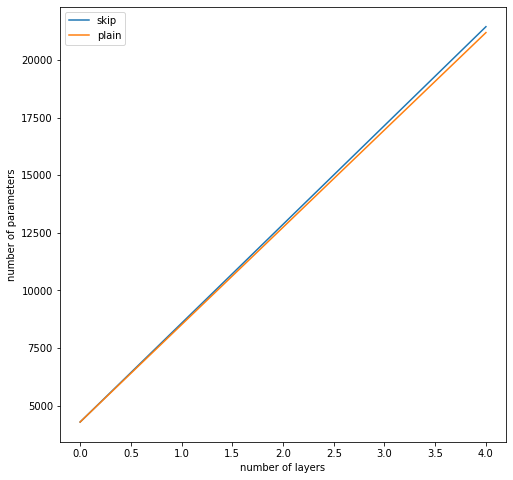

In [43]:
plt.plot(skip_params,label="skip")
plt.plot(plain_params,label="plain")
plt.xlabel("number of layers")
plt.ylabel("number of parameters")
plt.legend()
plt.show()

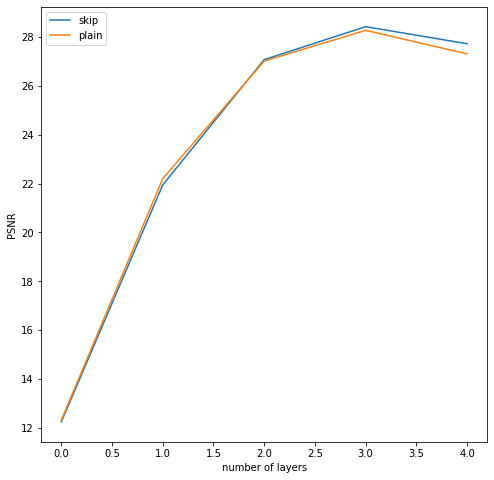

In [44]:
plt.plot(skip_psnr,label="skip")
plt.plot(plain_psnr,label="plain")
plt.xlabel("number of layers")
plt.ylabel("PSNR")
plt.legend()
plt.show()